# Лабораторная работа 1. Линейная регрессия и факторный анализ

## 1. Введение

**Цель работы:** изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качества.

**Постановка задачи:**

Провести обучение модели линейной регрессии на датасете с Kaggle:

1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ).

2. Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной. 

3. Провести предобработку данных: удалить пропущенные значения, закодировать категориальные переменные (опционально).

4. Построить матрицу корреляций. Сделать выводы о наличии мультиколлинеарности (расчет VIF-коэффициента).

5. Построить регрессионные модели (линейная и гребневая). Если целевая переменная - категориальная, то исследовать логистическую регрессию. Разделить на тренировочную и тестовую выборки (80/20 или 70/30). Использовать кросс-валидацию. Оценить качество построенной модели с помощью метрик: RMSE (Root Mean Square Error), R² (коэффициент детерминации) и MAPE (Mean Absolute Percentage Error).

6. Устранить мультиколлинеарность и снизить размерность признаков с помощью метода главных компонент (PCA). Перед проведением PCA провести стандартизацию данных.

7. Повторить шаг 5 (линейная и гребневая регрессия), но использовать в качестве признаков не исходные данные, а главные компоненты. Сравнить метрики качества (RMSE, R² и MAPE) моделей, обученных на исходных данных и на главных компонентах.

## 2. Описание датасета

В работе используется датасет Laptop Price Prediction с платформы Kaggle. Он содержит сведения о характеристиках ноутбуков различных брендов и их стоимости. Данные представлены в формате CSV и включают следующие признаки:

- Brand - производитель ноутбука (категориальный признак);
- Processor_Speed - тактовая частота процессора (ГГц);
- RAM_Size - объём оперативной памяти (ГБ);
- Storage_Capacity - объём накопителя (ГБ);
- Screen_Size - диагональ экрана (дюймы);
- Weight - вес устройства (кг);
- Price - цена ноутбука (целевая переменная).

Датасет содержит 1000 записей, охватывающих популярные бренды, такие как Asus, Acer, Lenovo, HP и Dell. Эти данные позволяют проанализировать, какие технические характеристики оказывают наибольшее влияние на цену ноутбука и построить модель для прогнозирования стоимости устройств.

## 3. Подготовка и предобработка данных

Загрузим данные из датасета:

In [16]:
import pandas as pd

file_path = "laptop_price.csv"
df = pd.read_csv(file_path)
df

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
0,Asus,3.830296,16,512,11.185147,2.641094,17395.093065
1,Acer,2.912833,4,1000,11.311372,3.260012,31607.605919
2,Lenovo,3.241627,4,256,11.853023,2.029061,9291.023542
3,Acer,3.806248,16,512,12.280360,4.573865,17436.728334
4,Acer,3.268097,32,1000,14.990877,4.193472,32917.990718
...,...,...,...,...,...,...,...
995,HP,3.343584,4,1000,12.587095,3.162399,31593.668017
996,Dell,2.780555,8,256,12.679356,3.750265,9149.521832
997,Dell,3.200569,4,512,12.666315,3.392612,16552.404779
998,Asus,1.604182,8,256,11.215581,3.857613,9407.473459


Посмотрим, с какими типами переменных предстоит работать, и проверим наличие пропущенных значений:

In [17]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand             1000 non-null   object 
 1   Processor_Speed   1000 non-null   float64
 2   RAM_Size          1000 non-null   int64  
 3   Storage_Capacity  1000 non-null   int64  
 4   Screen_Size       1000 non-null   float64
 5   Weight            1000 non-null   float64
 6   Price             1000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 54.8+ KB


Brand               0
Processor_Speed     0
RAM_Size            0
Storage_Capacity    0
Screen_Size         0
Weight              0
Price               0
dtype: int64

Команда df.info() показывает, что датасет состоит из 1000 записей и 7 столбцов. Пропущенные значения отсутствуют, что упрощает дальнейшую предобработку. Типы данных распределены следующим образом:

- Brand - object (строковый тип, категориальный признак);
- Processor_Speed, Screen_Size, Weight, Price - float64 (вещественные признаки);
- RAM_Size, Storage_Capacity - int64 (целочисленные признаки).

Таким образом, модель будет работать преимущественно с количественными (числовыми) признаками, за исключением одного категориального - Brand, который при необходимости можно закодировать с помощью методов.

Выведем основные статистические показатели:

In [18]:
df.describe().round(2)

,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,2.75,15.50,584.58,14.06,3.47,19604.19
std,0.73,10.99,313.44,1.71,0.87,9406.06
min,1.51,4.00,256.00,11.01,2.00,8570.01
25%,2.09,8.00,256.00,12.64,2.72,10114.01
50%,2.76,16.00,512.00,14.10,3.46,17287.24
75%,3.36,32.00,1000.00,15.53,4.21,31566.21
max,4.00,32.00,1000.00,16.99,4.99,33503.94


По результатам функции df.describe() видно, что все числовые признаки имеют 1000 наблюдений без пропусков.
Средняя тактовая частота процессора составляет около 2.75 ГГц, средний объём оперативной памяти - 15.5 ГБ, а средний объём хранилища - около 585 ГБ. Средняя диагональ экрана равна 14.06 дюйма, средний вес ноутбуков - 3.47 кг. Средняя цена устройств - около 19 604 рублей, при этом разброс цен достаточно велик (стандартное отклонение ≈ 9406), что указывает на разнообразие моделей по характеристикам и стоимости.

В целом, анализ показывает, что данные содержат признаки с разными шкалами измерений и неоднородными распределениями, что требует нормализации и масштабирования перед применением методов машинного обучения.

Визуализируем распределение признаков и целевой переменной:

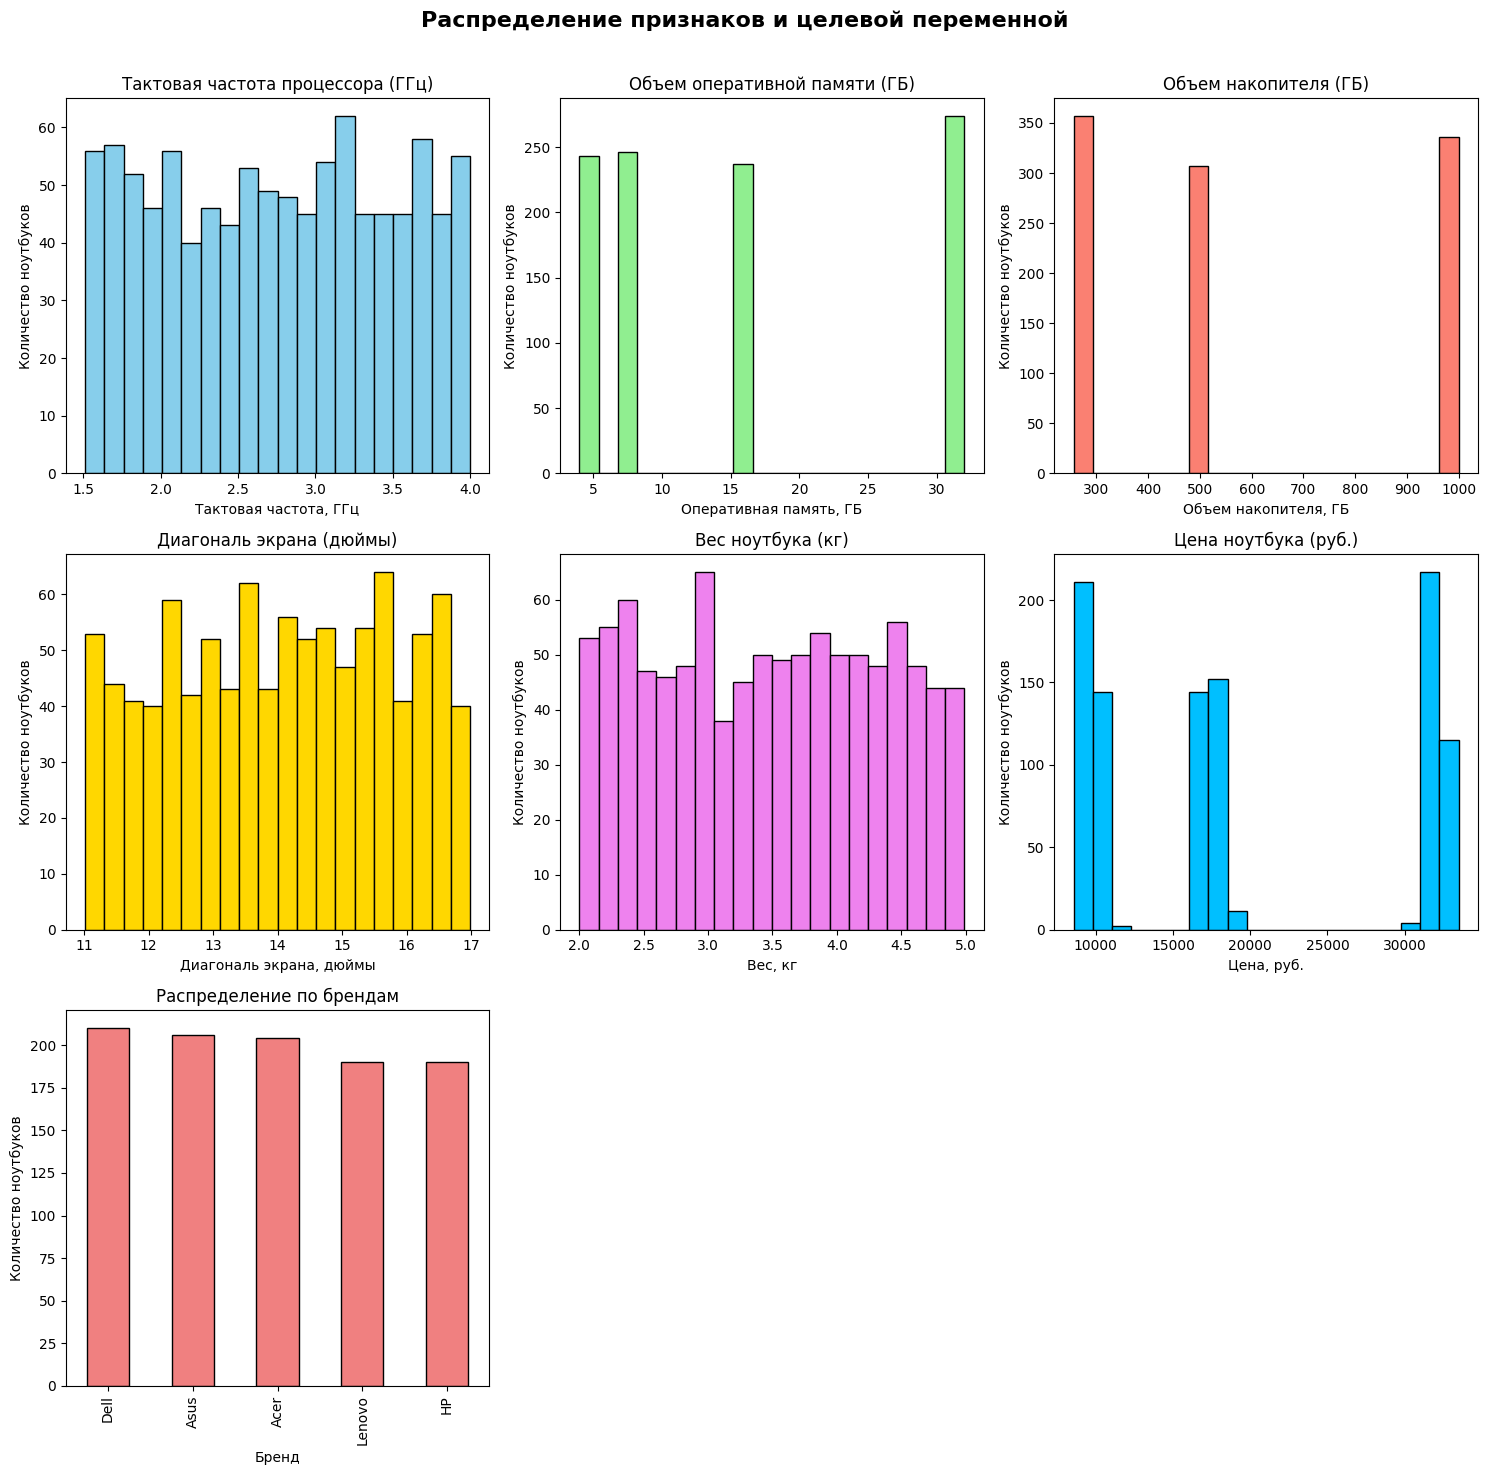

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

axes[0, 0].hist(df['Processor_Speed'], color='skyblue', edgecolor='black', bins=20)
axes[0, 0].set_title("Тактовая частота процессора (ГГц)")
axes[0, 0].set_xlabel("Тактовая частота, ГГц")
axes[0, 0].set_ylabel("Количество ноутбуков")

axes[0, 1].hist(df['RAM_Size'], color='lightgreen', edgecolor='black', bins=20)
axes[0, 1].set_title("Объем оперативной памяти (ГБ)")
axes[0, 1].set_xlabel("Оперативная память, ГБ")
axes[0, 1].set_ylabel("Количество ноутбуков")

axes[0, 2].hist(df['Storage_Capacity'], color='salmon', edgecolor='black', bins=20)
axes[0, 2].set_title("Объем накопителя (ГБ)")
axes[0, 2].set_xlabel("Объем накопителя, ГБ")
axes[0, 2].set_ylabel("Количество ноутбуков")

axes[1, 0].hist(df['Screen_Size'], color='gold', edgecolor='black', bins=20)
axes[1, 0].set_title("Диагональ экрана (дюймы)")
axes[1, 0].set_xlabel("Диагональ экрана, дюймы")
axes[1, 0].set_ylabel("Количество ноутбуков")

axes[1, 1].hist(df['Weight'], color='violet', edgecolor='black', bins=20)
axes[1, 1].set_title("Вес ноутбука (кг)")
axes[1, 1].set_xlabel("Вес, кг")
axes[1, 1].set_ylabel("Количество ноутбуков")

axes[1, 2].hist(df['Price'], color='deepskyblue', edgecolor='black', bins=20)
axes[1, 2].set_title("Цена ноутбука (руб.)")
axes[1, 2].set_xlabel("Цена, руб.")
axes[1, 2].set_ylabel("Количество ноутбуков")

df['Brand'].value_counts().plot(kind='bar', ax=axes[2, 0], color='lightcoral', edgecolor='black')
axes[2, 0].set_title("Распределение по брендам")
axes[2, 0].set_xlabel("Бренд")
axes[2, 0].set_ylabel("Количество ноутбуков")

axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)

plt.suptitle("Распределение признаков и целевой переменной", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


По результатам визуализации распределений признаков и целевой переменной можно сделать следующие выводы:

1. Тактовая частота процессора (Processor_Speed) распределена относительно равномерно в диапазоне от 1.5 до 4 ГГц, что говорит о наличии ноутбуков как с базовыми, так и с более производительными процессорами.

2. Оперативная память (RAM_Size) имеет дискретное распределение с явно выраженными пиками на значениях 8, 16 и 32 ГБ - это типичные объёмы, встречающиеся в современных моделях ноутбуков.

3. Объем накопителя (Storage_Capacity) также дискретен: преобладают варианты с 256, 512 и 1000 ГБ, что соответствует стандартным конфигурациям SSD и HDD.

4. Диагональ экрана (Screen_Size) распределена почти равномерно в диапазоне 11-17 дюймов, с незначительным смещением к наиболее популярным размерам 14-15 дюймов.

5. Вес ноутбуков (Weight) варьируется от 2 до 5 кг, большинство устройств имеют массу в пределах 3-4 кг, что типично для среднеформатных моделей.

6. Цена (Price) распределена неравномерно, наблюдаются несколько групп ноутбуков - в среднем ценовом сегменте (10-20 тыс. руб.) и в более дорогом (30 тыс. руб. и выше), что указывает на присутствие разных классов устройств.

7. Распределение по брендам (Brand) относительно сбалансировано: доля компаний Dell, Asus, Acer, Lenovo и HP примерно одинакова, что исключает сильный перекос выборки в пользу одного производителя.

Таким образом, данные демонстрируют разнородность и разнообразие ноутбуков по техническим характеристикам и ценам. Признаки имеют разные шкалы и частично дискретные распределения, что подтверждает необходимость масштабирования и нормализации данных перед обучением моделей линейной и гребневой регрессии.

Построим матрицу корреляций:

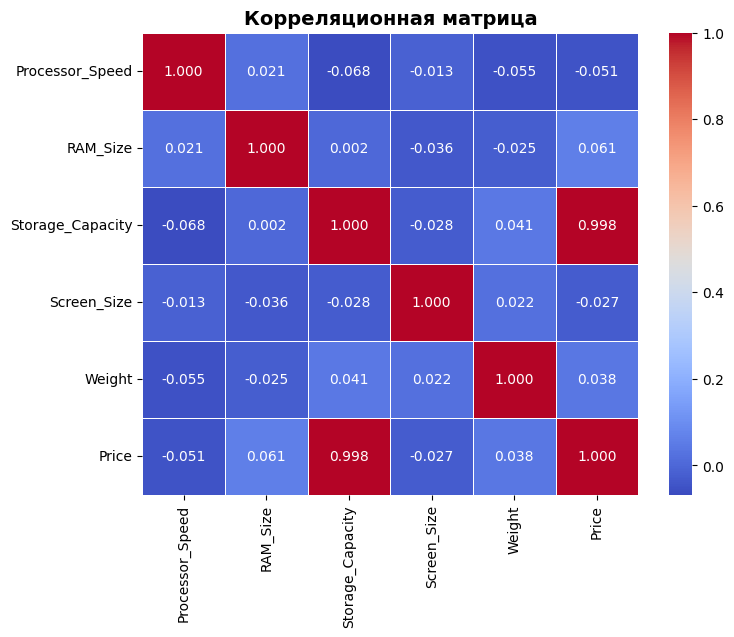

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df[['Processor_Speed', 'RAM_Size', 'Storage_Capacity', 
                  'Screen_Size', 'Weight', 'Price']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title("Корреляционная матрица", fontsize=14, fontweight='bold')
plt.show()


Построенная матрица корреляций показывает, что между большинством признаков наблюдается очень слабая взаимосвязь (коэффициенты корреляции близки к нулю). Это говорит о том, что признаки практически независимы друг от друга. Исключением является пара Storage_Capacity - Price, где коэффициент корреляции составляет 0.998, что указывает на почти идеальную линейную зависимость между объемом накопителя и ценой ноутбука.

Рассчитаем значения VIF-коэффициентов:

In [21]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[['Processor_Speed', 'RAM_Size', 'Storage_Capacity', 
        'Screen_Size', 'Weight']]

X_const = add_constant(X)

VIFs = pd.DataFrame()
VIFs['Переменная'] = X_const.columns
VIFs['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
display(VIFs)

,Переменная,VIF
0,const,108.095709
1,Processor_Speed,1.007906
2,RAM_Size,1.002303
3,Storage_Capacity,1.006904
4,Screen_Size,1.002734
5,Weight,1.005490


Значения VIF для всех признаков, кроме константы, находятся в диапазоне от 1.00 до 1.01, что указывает на полное отсутствие мультиколлинеарности между независимыми переменными. Это означает, что признаки не коррелируют друг с другом и вносят самостоятельный вклад в модель регрессии.

Высокое значение VIF у константы (≈108) является нормальным и не требует корректировки, так как константа не участвует в анализе взаимозависимостей признаков.

Следовательно, можно сделать вывод, что мультиколлинеарность в данных отсутствует, и все переменные могут быть использованы в модели без необходимости их исключения или преобразования.

Нормализуем признаки:

In [22]:
from sklearn.preprocessing import StandardScaler

features = ['Processor_Speed', 'RAM_Size', 'Storage_Capacity', 'Screen_Size', 'Weight']

scaler = StandardScaler()

df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

df_scaled

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
0,Asus,1.476128,0.045524,-0.231664,-1.684219,-0.953490,17395.093065
1,Acer,0.221788,-1.047057,1.326040,-1.610189,-0.238893,31607.605919
2,Lenovo,0.671310,-1.047057,-1.048819,-1.292510,-1.660138,9291.023542
3,Acer,1.443251,0.045524,-0.231664,-1.041877,1.278069,17436.728334
4,Acer,0.707499,1.502299,1.326040,0.547843,0.838871,32917.990718
...,...,...,...,...,...,...,...
995,HP,0.810704,-1.047057,1.326040,-0.861977,-0.351596,31593.668017
996,Dell,0.040939,-0.682863,-1.048819,-0.807865,0.327148,9149.521832
997,Dell,0.615176,-1.047057,-0.231664,-0.815514,-0.085795,16552.404779
998,Asus,-1.567379,-0.682863,-1.048819,-1.666370,0.451091,9407.473459


В ходе нормализации числовых признаков с помощью метода StandardScaler все значения были приведены к единому масштабу: среднее значение каждого признака стало равным нулю, а стандартное отклонение - единице. Это обеспечивает корректное применение методов машинного обучения, чувствительных к масштабу данных, таких как линейная и гребневая регрессия, а также позволяет выполнить метод главных компонент (PCA) без искажения вклада признаков.

Теперь, когда мы загрузили, обработали и исследовали данные, а также отобрали наиболее значимые признаки и нормализовали их - мы готовы к обучению модели.

Разобъем данные на обучающую и тестовую выборки с помощью функции train_test_split:

In [23]:
from sklearn.model_selection import train_test_split

X = df_scaled.drop(columns=['Brand', 'Price'])
y = df_scaled['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


X_train: (700, 5)
X_test: (300, 5)
y_train: (700,)
y_test: (300,)


Данные были успешно разделены в пропорции 70/30: обучающая выборка содержит 700 наблюдений с 5 признаками, тестовая - 300 наблюдений с теми же 5 признаками; целевая переменная имеет размеры, соответствующие выборкам (700 и 300).

## 4. Ход работы

### Реализация регрессии до устранения мультиколлинеарности

#### Линейная регрессия:

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

model = LinearRegression()

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("Значения R² на кросс-валидации:", cv_scores)
print("Средний R² (CV):", cv_scores.mean())
print("-" * 50)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse_lin = root_mean_squared_error(y_test, y_pred)
mape_lin = mean_absolute_percentage_error(y_test, y_pred)
r2_lin = r2_score(y_test, y_pred)

print(f"RMSE: {rmse_lin:.4f}")
print(f"MAPE: {mape_lin:.4f}")
print(f"R²: {r2_lin:.4f}")
print("-" * 50)
print(f"Коэффициенты модели: {model.coef_}")
print(f"Свободный член (intercept): {model.intercept_}")


Значения R² на кросс-валидации: [0.99934096 0.99953355 0.99954628 0.99967411 0.99956676]
Средний R² (CV): 0.9995323322289649
--------------------------------------------------
RMSE: 190.6073
MAPE: 0.0098
R²: 0.9996
--------------------------------------------------
Коэффициенты модели: [ 1.53208923e+02  5.54287352e+02  9.39704011e+03  2.96494126e+01
 -6.65553546e+00]
Свободный член (intercept): 19603.550862647935


Построенная модель линейной регрессии продемонстрировала высокое качество предсказаний. Среднее значение коэффициента детерминации на кросс-валидации составило R² = 0.9995, что указывает на практически полное объяснение вариации целевой переменной признаками модели.

Значения метрик на тестовой выборке также подтверждают отличное качество:
- RMSE = 190.61 - среднеквадратичная ошибка мала по сравнению с диапазоном цен,
- MAPE = 0.0098 - средняя относительная ошибка менее 1%,
- R² = 0.9996 - модель описывает 99.96% дисперсии цены ноутбуков.

Наибольшее влияние на итоговую цену оказывает признак Storage_Capacity, что согласуется с ранее выявленной высокой корреляцией между ним и стоимостью. Остальные признаки вносят незначительный вклад.

Таким образом, линейная регрессия показала почти идеальные результаты на данных, что может указывать на синтетический характер датасета или сильную линейную зависимость между характеристиками и ценой ноутбука.

#### Гребневая регрессия:

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

ridge_model = Ridge()

cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='r2')
print("Значения R² на кросс-валидации:", cv_scores)
print("Средний R² (CV):", cv_scores.mean())
print("-" * 50)

ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

rmse_ridge = root_mean_squared_error(y_test, y_pred)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred)
r2_ridge = r2_score(y_test, y_pred)

print(f"RMSE: {rmse_ridge:.4f}")
print(f"MAPE: {mape_ridge:.4f}")
print(f"R²: {r2_ridge:.4f}")
print("-" * 50)
print(f"Коэффициенты модели: {ridge_model.coef_}")
print(f"Свободный член (intercept): {ridge_model.intercept_}")


Значения R² на кросс-валидации: [0.99934378 0.99953023 0.99951861 0.99967487 0.99957743]
Средний R² (CV): 0.99952898439749
--------------------------------------------------
RMSE: 189.7349
MAPE: 0.0098
R²: 0.9996
--------------------------------------------------
Коэффициенты модели: [ 1.52176396e+02  5.53551683e+02  9.38347099e+03  2.91480846e+01
 -5.71680002e+00]
Свободный член (intercept): 19603.46644383405


Модель гребневой регрессии показала результаты, практически идентичные линейной модели. Средний коэффициент детерминации на кросс-валидации составил R² = 0.9995, что свидетельствует о высокой устойчивости и точности модели при различных разбиениях данных.

На тестовой выборке модель также продемонстрировала отличные показатели:
- RMSE = 189.73 - среднеквадратичная ошибка минимальна;
- MAPE = 0.0098 - средняя относительная ошибка менее 1%;
- R² = 0.9996 - модель объясняет 99.96% вариации цены ноутбуков.

Коэффициенты при признаках по величине и знаку почти полностью совпадают с результатами линейной регрессии, что говорит о низкой мультиколлинеарности и стабильности модели. Наибольшее влияние на цену, как и прежде, оказывает параметр Storage_Capacity, тогда как остальные признаки имеют незначительный эффект.

Таким образом, гребневая регрессия подтвердила высокое качество и устойчивость прогноза, при этом не показав существенного улучшения по сравнению с обычной линейной моделью, что связано с хорошо сбалансированной структурой исходных данных.

### Реализация регрессии после устранения мультиколлинеарности

#### Устранение мультиколлинеарности и снижение размерности признаков с помощью метода главных компонент (PCA)

Для начала, построим график метода локтя для определения количества компонент:

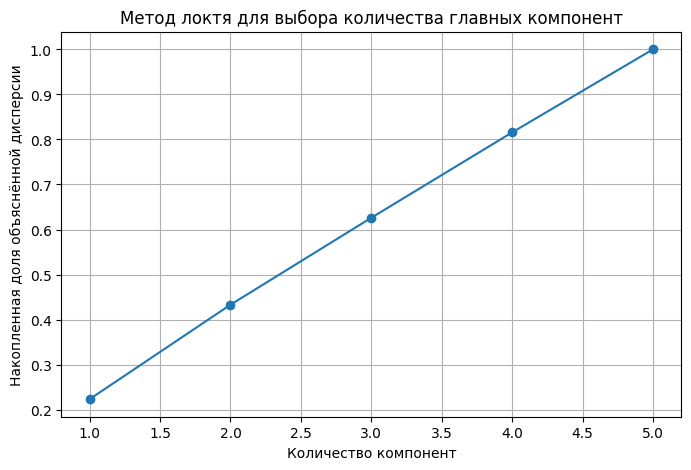

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_scaled = df_scaled.drop(columns=['Brand', 'Price'])

pca = PCA()
pca.fit(X_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.title('Метод локтя для выбора количества главных компонент')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная доля объяснённой дисперсии')
plt.grid(True)
plt.show()


Построенный график метода локтя показывает, что каждая новая главная компонента вносит примерно одинаковый вклад в общую дисперсию данных, а накопленная доля объяснённой вариации возрастает почти линейно и достигает 100% только при использовании всех пяти компонент.

Такое поведение говорит о том, что между признаками отсутствует выраженная избыточность - то есть каждый из исходных признаков несёт самостоятельную информацию и не дублирует другие. Это согласуется с ранее полученными низкими значениями VIF и слабой корреляцией между признаками.

Таким образом, метод главных компонент не выявил сильной мультиколлинеарности, а снижение размерности не даст существенного прироста эффективности. Однако для сравнения моделей можно выбрать, например, 3 или 4 главные компоненты, что позволит слегка упростить модель при сохранении более 90–95% объяснённой дисперсии:

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

X_pca = pca.fit_transform(X_scaled)

print("Исходное количество признаков:", X_scaled.shape)
print("После PCA:", X_pca.shape)


Исходное количество признаков: (1000, 5)
После PCA: (1000, 4)


#### Линейная регрессия:

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

model = LinearRegression()

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("Значения R² на кросс-валидации:", cv_scores)
print("Средний R² (CV):", cv_scores.mean())
print("-" * 50)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse_lin_pca = root_mean_squared_error(y_test, y_pred)
mape_lin_pca = mean_absolute_percentage_error(y_test, y_pred)
r2_lin_pca = r2_score(y_test, y_pred)

print(f"RMSE: {rmse_lin_pca:.4f}")
print(f"MAPE: {mape_lin_pca:.4f}")
print(f"R²: {r2_lin_pca:.4f}")
print("-" * 50)
print(f"Коэффициенты модели: {model.coef_}")
print(f"Свободный член (intercept): {model.intercept_}")


Значения R² на кросс-валидации: [0.45544591 0.59914181 0.53239234 0.57211267 0.59498673]
Средний R² (CV): 0.5508158913059386
--------------------------------------------------
RMSE: 6386.1287
MAPE: 0.3320
R²: 0.5387
--------------------------------------------------
Коэффициенты модели: [-4626.84149316 -4660.81578902  -670.42367407 -2023.09366086]
Свободный член (intercept): 19599.54437461888


После снижения размерности до четырёх главных компонент качество модели заметно снизилось по сравнению с исходной линейной регрессией. Средний коэффициент детерминации на кросс-валидации составил R² = 0.55, а на тестовой выборке - R² = 0.54, что означает, что модель объясняет лишь около 54% вариации цены ноутбуков.

Ошибки существенно выросли:
- RMSE = 6386.13 - среднеквадратичная ошибка увеличилась почти в 30 раз,
- MAPE = 0.332 - средняя относительная ошибка около 33%, что указывает на низкую точность предсказаний.

Такие результаты объясняются тем, что при применении PCA часть информации о взаимосвязях между исходными признаками была потеряна. Ранее модель объясняла почти всю дисперсию цены за счёт сильной линейной зависимости между ценой и объёмом накопителя. После преобразования в главные компоненты эта зависимость размывается, и модель теряет способность точно прогнозировать.

Таким образом, применение PCA в данном случае ухудшило качество линейной регрессии, поскольку исходные признаки не содержали мультиколлинеарности и уже были оптимально информативны для предсказания цены.

#### Гребневая регрессия:

In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

ridge_model = Ridge()

cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='r2')
print("Значения R² на кросс-валидации:", cv_scores)
print("Средний R² (CV):", cv_scores.mean())
print("-" * 50)

ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

rmse_ridge_pca = root_mean_squared_error(y_test, y_pred)
mape_ridge_pca = mean_absolute_percentage_error(y_test, y_pred)
r2_ridge_pca = r2_score(y_test, y_pred)

print(f"RMSE: {rmse_ridge_pca:.4f}")
print(f"MAPE: {mape_ridge_pca:.4f}")
print(f"R²: {r2_ridge_pca:.4f}")
print("-" * 50)
print(f"Коэффициенты модели: {ridge_model.coef_}")
print(f"Свободный член (intercept): {ridge_model.intercept_}")


Значения R² на кросс-валидации: [0.45561931 0.59918185 0.53243277 0.57200482 0.59489419]
Средний R² (CV): 0.5508265892822143
--------------------------------------------------
RMSE: 6385.5546
MAPE: 0.3319
R²: 0.5388
--------------------------------------------------
Коэффициенты модели: [-4620.91377222 -4654.29366059  -669.37048033 -2019.75481057]
Свободный член (intercept): 19599.46702718202


Модель гребневой регрессии, обученная на четырёх главных компонентах, показала результаты, практически совпадающие с линейной регрессией после PCA. Средний коэффициент детерминации на кросс-валидации составил R² = 0.55, а на тестовой выборке - R² = 0.54, что означает, что модель объясняет около 54% вариации цены ноутбуков.

Показатели ошибок также остались высокими:
- RMSE = 6385.55 - среднеквадратичная ошибка существенно выше, чем у исходной модели;
- MAPE = 0.3319 - средняя относительная ошибка около 33%, что свидетельствует о заметной потере точности.

Таким образом, применение метода главных компонент привело к ухудшению качества модели, так как при снижении размерности часть информации о взаимосвязях между признаками была утрачена. В исходных данных мультиколлинеарность отсутствовала, поэтому использование PCA оказалось нецелесообразным.

### Сравнительный анализ

In [30]:
import pandas as pd

results = pd.DataFrame({
    'Модель': [
        'Линейная регрессия (без PCA)',
        'Гребневая регрессия (без PCA)',
        'Линейная регрессия (с PCA)',
        'Гребневая регрессия (с PCA)'
    ],
    'RMSE': [
        rmse_lin,
        rmse_ridge,
        rmse_lin_pca,
        rmse_ridge_pca
    ],
    'MAPE': [
        mape_lin,
        mape_ridge,
        mape_lin_pca,
        mape_ridge_pca
    ],
    'R²': [
        r2_lin,
        r2_ridge,
        r2_lin_pca,
        r2_ridge_pca
    ]
})

print('\nСравнительная таблица метрик качества моделей:')
print(results.round(4))



Сравнительная таблица метрик качества моделей:
                          Модель       RMSE    MAPE      R²
0   Линейная регрессия (без PCA)   190.6073  0.0098  0.9996
1  Гребневая регрессия (без PCA)   189.7349  0.0098  0.9996
2     Линейная регрессия (с PCA)  6386.1287  0.3320  0.5387
3    Гребневая регрессия (с PCA)  6385.5546  0.3319  0.5388


Сравнительная таблица показывает, что модели, построенные на исходных признаках (без PCA), значительно превосходят по качеству модели, обученные на главных компонентах.

Линейная и гребневая регрессии без PCA продемонстрировали практически идеальные результаты:
- R² ≈ 0.9996 - модель объясняет почти всю вариацию цены;
- RMSE ≈ 190 и MAPE ≈ 0.0098 - ошибки минимальны.

После применения PCA качество резко ухудшилось:
- R² снизился до ≈ 0.54,
- RMSE вырос более чем в 30 раз,
- MAPE увеличился до 33%, что указывает на значительную потерю точности.

Таким образом, можно сделать вывод, что в исходных данных мультиколлинеарность отсутствовала, а все признаки несли важную информацию для прогнозирования. Поэтому использование метода главных компонент привело к потере информативности и ухудшению качества предсказаний.

Наилучшие результаты показали линейная и гребневая регрессии без PCA, что делает их оптимальными моделями для данного набора данных.

## 5. Заключение

В ходе лабораторной работы были реализованы и сравнены модели линейной и гребневой регрессии на датасете, содержащем характеристики ноутбуков. Модели строились как на исходных стандартизированных данных, так и после применения метода главных компонент (PCA) для снижения размерности признаков.

Результаты показали, что при использовании исходных данных обе модели продемонстрировали высокое качество предсказаний - коэффициент детерминации R² ≈ 0.9996, а значения ошибок RMSE ≈ 190 и MAPE ≈ 1% указывают на практически идеальное соответствие прогнозов фактическим значениям.

После применения PCA качество моделей существенно снизилось: R² упал до ~0.54, а ошибки RMSE и MAPE значительно выросли. Это связано с тем, что при снижении размерности часть информации о взаимосвязях между признаками была утрачена. Поскольку исходные данные не содержали мультиколлинеарности, использование PCA оказалось нецелесообразным.

Таким образом, наилучшие результаты для данного набора данных показали линейная и гребневая регрессии без PCA, что подтверждает достаточную информативность исходных признаков и отсутствие необходимости в снижении размерности.